In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline
import import_ipynb
import random
from matplotlib.gridspec import GridSpec

In [2]:
import os
os.chdir('F:/我的雲端硬碟/Retina exp/python code/functions')
import import_ipynb
import NGDfunc
from NGDfunc import MI,xcorr_quick,NGD,poisson,EqualState,OU,FFT_quick


importing Jupyter notebook from NGDfunc.ipynb


## Load data / find cross-correlation of ganglion cell output

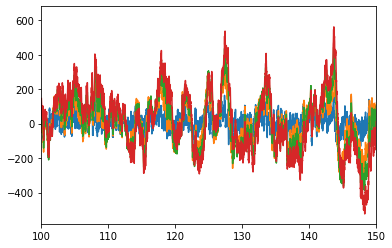

In [3]:
dt_ou=0.01 # the sampling rate of OU; same to experiment
dt=0.01 # iteration step for euler method
tau_ou=[0.1,0.6,1,1.8]
T_ou=300
nsteps_ou=int(T_ou/dt_ou)
amp=2
mean=10
randseed = np.random.normal(0, 50, nsteps_ou)
x_ou=[0 for i in range(len(tau_ou))]
for i in range(len(tau_ou)):
    time_ou,x_ou[i]=OU(T_ou,tau_ou[i],'no',dt_ou,randseed)

x_set=[x_ou[i]*amp+mean for i in range(len(tau_ou))]
for i in range(len(x_set)):
#     x_set[i]=np.repeat(x_set[i],10)
    time=np.arange(1,len(x_set[0])+1e-5)*dt
    plt.plot(time,x_set[i])
    plt.xlim(100,150)


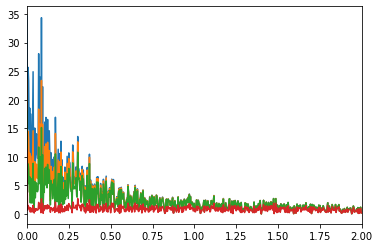

In [4]:
a=[0 for i in range(len(x_set))]
for i in range(len(x_set)):
    f,a[i],ph=FFT_quick(x_set[-i-1],dt)
    plt.plot(f,a[i])
    plt.xlim(0,2)
#     plt.ylim(0,30)
# plt.yscale('log')
    

## NGD output

In [5]:
alpha,beta,K,g=6,1.6,22,10 # channel 39
# alpha,beta,K,g=8,1.4,37,10 # channel 47
y_set=[NGD(x_set[j],dt,alpha,beta,K,g,1)[0] for j in range(np.size(x_set,0))] 
z_set=[NGD(x_set[j],dt,alpha,beta,K,g,1)[1] for j in range(np.size(x_set,0))] 

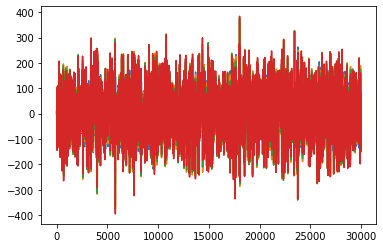

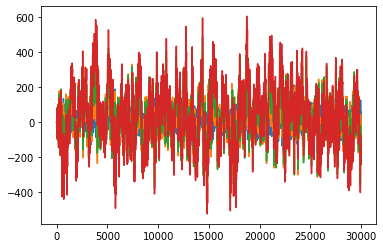

In [6]:
for i in range(4):
    plt.plot(y_set[i])
plt.ylim()
plt.xlim()
plt.show()
for i in range(4):
    plt.plot(z_set[i])
# plt.ylim(-1,4)
# plt.xlim(2000,4000)

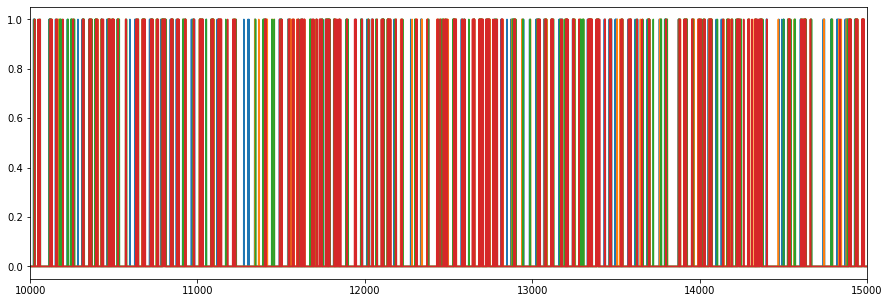

In [7]:
f0,ax0=plt.subplots(figsize=(15,5))
spikeon_fc=[0 for i in range(len(x_set))]
MI_fc=[0 for i in range(len(x_set))]
MI_fc=[0 for i in range(len(x_set))]
for j in range(len(x_set)):
    spikeon_fc[j]=poisson(y_set[j],0,0,dt)
    tl_fc,MI_fc[j]=MI(EqualState(x_set[j],8),spikeon_fc[j],dt,[-1,1])
    
    ax0.plot(spikeon_fc[j])
    ax0.set_xlim(10000,15000)

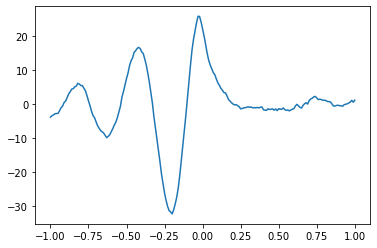

In [8]:
numset=0
ts,corr_ou=xcorr_quick(x_set[numset]-np.mean(x_set[numset]),spikeon_fc[numset],[-1,1],dt)
plt.plot(ts,corr_ou/np.sum(spikeon_fc[numset]))


Text(0.5, 0, 'time to spike (s)')

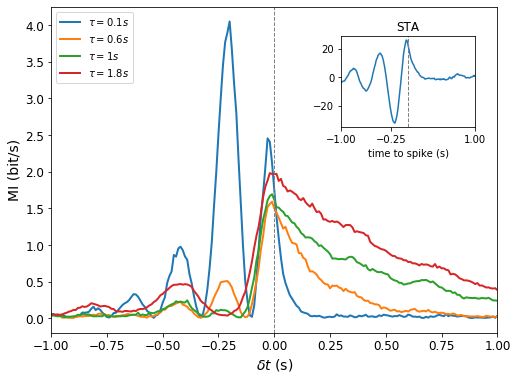

In [9]:
f0mi,ax0mi=plt.subplots(figsize=(8,6))
ax_inset=ax0mi.inset_axes([0.65, 0.63, 0.3, 0.28])
for j in range(len(x_set)):    
    ax0mi.plot(tl_fc,MI_fc[j],lw=2)
ax0mi.set_xlim(-1,1)
ax0mi.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
# ax0mi.set_ylim(0,1.1)
ax0mi.tick_params(axis='x',labelsize='12')
ax0mi.tick_params(axis='y',labelsize='12')
ax0mi.set_xlabel(r'$\delta t$ (s)',fontsize='14')
ax0mi.set_ylabel('MI (bit/s)',fontsize='14')
ax0mi.legend((r'$\tau=0.1s$',r'$\tau=0.6s$',r'$\tau=1s$',r'$\tau=1.8s$'),bbox_to_anchor=(0,0.5,0.5,0.5))
ax_inset.plot(ts,corr_ou/np.sum(spikeon_fc[0]))
ax_inset.set_title('STA')
ax_inset.xaxis.set_ticks([-1,-0.25,1])
ax_inset.set_xlim(-1,1)
ax_inset.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
# ax_inset.set_ylim(-0.6,0.8)
ax_inset.tick_params()
ax_inset.set_xlabel('time to spike (s)')



In [10]:
f0mi.savefig('F:/我的雲端硬碟/Master Thesis/Figures/Simulation result/OU tau sim.pdf')

## Adding horizontal feedback to NGD output (y+z)

### MI and cross correlation of B

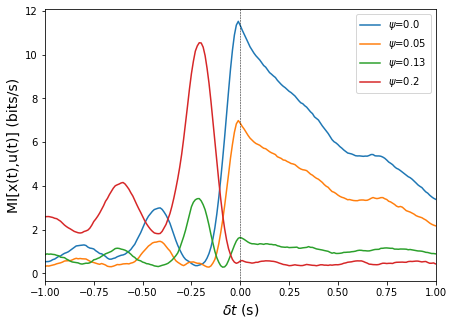

In [11]:
fpsi,axpsi=plt.subplots(figsize=(7,5))
psi_set=np.array([0,0.05,0.13,0.2])
# wy=0.9
# wy=[]
iamp=3
x=x_set[iamp]
y=y_set[iamp]
z=z_set[iamp]
B=[(1-psi_set[k])*y-psi_set[k]*z for k in range(len(psi_set))]
MIxyz=[[] for i in range(len(B))]
corrxyz=[[] for i in range(len(B))]
for k in range(len(B)):
    tsxyz,MIxyz[k]=MI(EqualState(x,8),EqualState(B[k],8),dt,[-2,2])
    tc,corrxyz[k]=xcorr_quick(x,B[k],[-5,5],dt)
# color2=['k','r']
for i in range(len(B)):
    plt.plot(tsxyz,MIxyz[i],label=r'$\psi$='+str(round(psi_set[i],3)))
plt.legend(fontsize=10)
plt.xlim(-1,1)
plt.ylabel(r'MI[x(t),u(t)] (bits/s)',fontsize=14)
plt.xlabel('$\delta t$ (s)',fontsize=14)
plt.axvline(x=0,c='k',linewidth=0.5,linestyle='dashed')


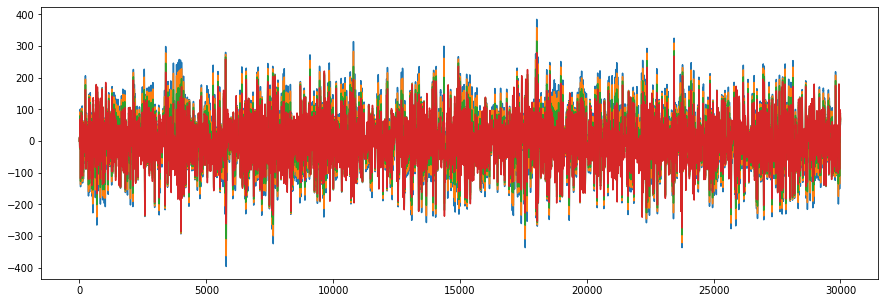

In [12]:
f,ax=plt.subplots(figsize=(15,5))
for i in range(len(psi_set)):
    plt.plot(B[i])

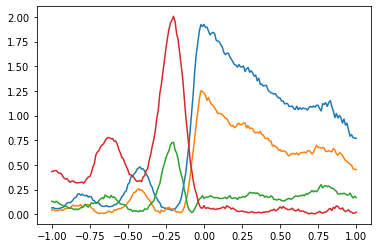

In [13]:
for i in range(len(psi_set)):
    spike_psi=poisson(B[i],2,1,dt)
    tl,MI_psi=MI(EqualState(x,8),spike_psi,dt,[-1,1])
    plt.plot(tl,MI_psi)

### NGD with ff different fc test

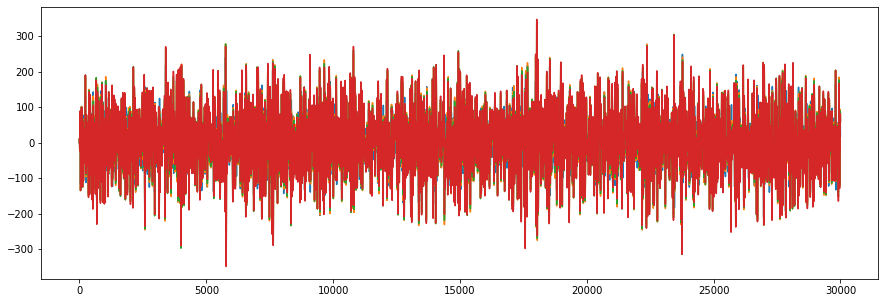

In [14]:
# P cell
psi=0.07
u1=[(1-psi)*y_set[i]-psi*z_set[i] for i in range(len(x_set))]
ff,axx=plt.subplots(figsize=(15,5))
for i in range(len(u1)):
    plt.plot(u1[i])

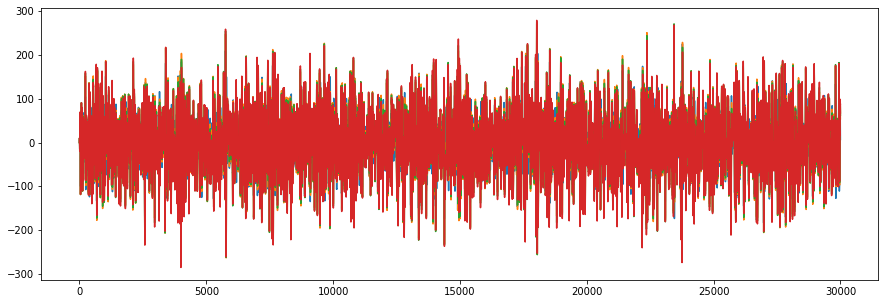

In [15]:
# NP cell
psi=0.2
u2=[(1-psi)*y_set[i]-psi*z_set[i] for i in range(len(x_set))]
ff,axx=plt.subplots(figsize=(15,5))
for i in range(len(u2)):
    plt.plot(u2[i])

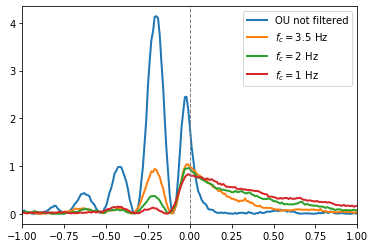

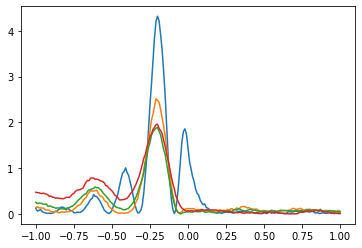

In [16]:
# P cell
MI_u1=[0 for i in range(len(x_set))]
fu1,axu1=plt.subplots(figsize=(6,4))
for i in range(len(x_set)):
    spikes_u1_on=poisson(u1[i],1.9,0,dt)
    tl,MI_u1[i]=MI(EqualState(x_set[i],8),spikes_u1_on,dt,[-1,1])
    plt.plot(tl,MI_u1[i],lw=2)
    plt.xlim(-1,1)
plt.legend(('OU not filtered',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'))
plt.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
# NP cell
MI_u2=[0 for i in range(len(x_set))]

fu2,axu2=plt.subplots(figsize=(6,4))
for i in range(len(x_set)):
    spikes_u2_on=poisson(u2[i],0,1,dt)
    tl,MI_u2[i]=MI(EqualState(x_set[i],8),spikes_u2_on,dt,[-1,1])
    plt.plot(tl,MI_u2[i])

In [17]:
x_fc=np.array(fc)
TSpeak_P=[0 for i in range(len(x_set))]
TSpeak_NP=[0 for i in range(len(x_set))]
for i in range(len(x_set)):
    loc1=np.argmax(MI_u1[i][tl>-0.1])
    TSpeak_P[i]=tl[tl>-0.1][loc1]
    loc2=np.argmax(MI_u2[i])
    TSpeak_NP[i]=tl[loc2]

plt.plot(fc,TSpeak_P[1:],'o')
plt.plot(fc,TSpeak_NP[1:],'o')

NameError: name 'fc' is not defined

In [ ]:
fyz=plt.figure(figsize=(10,6))
gs = GridSpec(5, 2, figure=fyz)
axsub1=fyz.add_subplot(gs[2:,0])
axsub2=fyz.add_subplot(gs[2:,1])
axsub3=fyz.add_subplot(gs[0:2,:])
lb_size=13

for i in range(len(x_set)):axsub1.plot(tl,MI_u1[i])
for i in range(len(x_set)):axsub2.plot(tl,MI_u2[i])
axsub1.set_xlim(-1,1)
axsub2.set_xlim(-1,1)
axsub1.set_ylim(0,4.6)
axsub2.set_ylim(0,2.1)
axsub2.yaxis.set_ticks([0,0.5,1,1.5,2])
axsub1.xaxis.set_ticks([-1,-0.5,0,0.5,1])
axsub2.xaxis.set_ticks([-1,-0.5,0,0.5,1])
axsub1.set_ylabel('MI (bit/s)',fontsize=lb_size)
axsub2.set_ylabel('MI (bit/s)',fontsize=lb_size)
axsub1.set_xlabel(r'$\delta t$ (s)',fontsize=lb_size)
axsub2.set_xlabel(r'$\delta t$ (s)',fontsize=lb_size)
axsub1.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
axsub2.axvline(x=0,linewidth=1,linestyle='--',color=[0.5,0.5,0.5])
axsub1.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'))
axsub2.legend(('OU not filtered',r'$f_c=5$ Hz',r'$f_c=3.5$ Hz',r'$f_c=2$ Hz',r'$f_c=1$ Hz'))
axsub1.set_title(r'$\psi=0.07$')
axsub2.set_title(r'$\psi=0.2$')

l1=axsub3.plot(time,y_set[2],c='b',label=r'$y(t)$')
axsub3.set_ylim(-3,6)
axsub3_2=axsub3.twinx()
# axsub3_3=axsub3.twinx()
# axsub3_3.spines['right'].set_position(("axes", 1.1))
l2=axsub3_2.plot(time,z_set[2],c='r',label=r'$z(t)$')
l3=axsub3_2.plot(time,x_set[2],c='g',label=r'$x(t)$')
axsub3_2.set_ylim(3,14)
axsub3.set_xlim(105,112)
axsub3.set_ylabel(r'$y(t)$',fontsize=lb_size)
axsub3_2.set_ylabel(r'$x(t), z(t)$',fontsize=lb_size)
axsub3.set_xlabel('time (s)',fontsize=lb_size)
lall=l3+l1+l2
labs = [l.get_label() for l in lall]
lg=axsub3_2.legend(lall, labs, loc=0, facecolor='white',framealpha=1)

# axsub4.plot(fc,TSpeak_P[1:],'o',c='r')
# axsub4.plot(fc,TSpeak_NP[1:],'o',c='k')

# for i in range(len(B)):
#     axsub5.plot(tsxyz,MIxyz[i],label=r'$\psi$='+str(round(psi_set[i],3)))

fyz.tight_layout() 

In [ ]:
fyz.savefig('F:/我的雲端硬碟/Master Thesis/Figures/Simulation result/PandNP cell.pdf')

### white noise STA

In [ ]:
dt=0.01
T_ou=300
amp_white=2
x_white=np.random.normal(0, amp_white, nsteps_ou)
plt.plot(x_white)

In [ ]:
# white noise STA
from NGDfunc import xcorr_quick
psi_white=[0,0.1,0.2]
y_white,z_white=NGD(x_white,dt,alpha,beta,K,g,1)
# spikes_white_on=[0 for i in range(len(B_white))]
# spikes_white_off=[0 for i in range(len(B_white))]
u_white=[(1-psi_white[k])*y_white-psi_white[k]*z_white for k in range(len(psi_white))]
f_1,ax_1=plt.subplots()
f_2,ax_2=plt.subplots()
threshold=0
for i in range(len(u_white)):
    spikes_white_on=poisson(u_white[i],threshold,0,dt)
    spikes_white_off=poisson(u_white[i],threshold,1,dt)
    tlcorr,corr_white_onspike=xcorr_quick(x_white,spikes_white_on,[-1,0],dt)
    tlcorr,corr_white_offspike=xcorr_quick(x_white,spikes_white_off,[-1,0],dt)
    ax_1.plot(tlcorr,corr_white_onspike/max(corr_white_onspike))
    ax_2.plot(tlcorr,corr_white_offspike/max(corr_white_offspike))

In [ ]:
for i in range(len(u_white)):
    plt.plot(u_white[i])

### calculate STA

In [ ]:
STAwindow=5
PoissonSTA_set=[[] for i in range(np.size(SpikeTrains_Poisson,0))]
for ii in range(np.size(SpikeTrains_Poisson,0)):
    sss=np.zeros(int(1+STAwindow/dt*2))
    n_spikes=0
    for i in range(len(SpikeTrains_Poisson[ii])):
        if SpikeTrains_Poisson[ii][i]>0:
            if (i-int(STAwindow/dt)>0) & (i+int(STAwindow/dt)<len(SpikeTrains_Poisson[ii])-1):
                n_spikes+=SpikeTrains_Poisson[ii][i]
                sss+=SpikeTrains_Poisson[ii][i]*x[i-int(STAwindow/dt):i+int(STAwindow/dt)+1]
    PoissonSTA_set[ii]=sss/n_spikes
t2s=np.arange(-5,5+1e-5,dt)

for j in range(np.size(SpikeTrains_Poisson,0)):
    plt.plot(t2s,PoissonSTA_set[j],label='w='+str(round(wy[j],3)))
plt.ylabel('STA')
plt.xlabel('$\delta t$ (s)')
plt.legend()
plt.xlim(-1,1)
plt.show()

## NGD Adding gain control

### feedback loop from y output to x input

In [ ]:
def NGD_FBFF_GainControl(xin,h=0,psi=0.1):
    alpha,beta,gamma,K,g=6,1.6,1,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    GC=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(GC[i]*xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*y[i])
        dv=dt*(-gamma*v[i]+h*y[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        GC[i+1]=1/(1+v[i+1]**4)
    B=(1-psi)*y-psi*z
    return y,z,v,GC,B

In [ ]:
y_h0,z_h0,v_h0,GC_h0,B_h0=NGD_FBFF_GainControl(x)
y_h1,z_h1,v_h1,GC_h1,B_h1=NGD_FBFF_GainControl(x,1,0.13)
y_1,z_1,v_1,GC_1,B_1=NGD_FBFF_GainControl(x1_set[1],1,0.13)

f1,ax1=plt.subplots(figsize=(15,5))
plt.plot(y_h0)
plt.plot(y_h1)
plt.plot(y_1)
plt.ylim(-2.5,5)
plt.xlim(3000,6000)

In [ ]:
from NGDfunc import EqualState
from NGDfunc import MI

tl,MI_yh0=MI(EqualState(x,8),EqualState(y_h0,8),dt,[-1,1])
tl,MI_yh1=MI(EqualState(x,8),EqualState(y_h1,8),dt,[-1,1])

plt.plot(tl,MI_yh0)
plt.plot(tl,MI_yh1)
plt.show()

tl,MI_Bh0=MI(EqualState(x,8),EqualState(B_h0,8),dt,[-2,2])
tl,MI_Bh1=MI(EqualState(x,8),EqualState(B_h1,8),dt,[-2,2])
tl,MI_Bnew=MI(EqualState(x,8),EqualState(B_1,8),dt,[-2,2])

plt.plot(tl,MI_Bh0)
plt.plot(tl,MI_Bh1)
plt.plot(tl,MI_Bnew)

In [ ]:
ff,axx=plt.subplots(figsize=(15,5))
plt.plot(x-5)
plt.plot(GC_h1)
plt.plot(B_h0)
plt.plot(B_h1)
plt.ylim(-2,5)
plt.xlim(2000,5000)

In [ ]:
spikes_h1_on=poisson(B_h1,0,0)
spikes_h1_off=poisson(B_h1,0,1)
plt.subplots(figsize=(15,5))
plt.plot(spikes_h1_on)
plt.plot(spikes_h1_off)

tl,MIspikes_h1_on=MI(EqualState(x,8),spikes_h1_on,dt,[-2,2])
tl,MIspikes_h1_off=MI(EqualState(x,8),spikes_h1_off,dt,[-2,2])
plt.subplots(figsize=(6,4))
plt.plot(tl,MIspikes_h1_on)
plt.plot(tl,MIspikes_h1_off)

from NGDfunc import xcorr_quick
xx=x-np.mean(x)
tl,corr_on=xcorr_quick(xx,spikes_h1_on,[-2,2],dt)
tl,corr_off=xcorr_quick(xx,spikes_h1_off,[-2,2],dt)
plt.subplots(figsize=(6,4))
plt.plot(tl,corr_on)
plt.plot(tl,corr_off)

### inputs with different contrast

In [ ]:
f1,ax1=plt.subplots()
f2,ax2=plt.subplots()
B_cst=[0 for k in range(len(x_set))]
for ii in range(len(x_set)):
    x=x_set[ii]
    y_cst,z_cst,v_cst,GC_cst,B_cst[ii]=NGD_FBFF_GainControl(x,0,0.1)
    tl,MI_cst=MI(EqualState(x,8),EqualState(B_cst[ii],8),dt,[-1,1])
    ax1.plot(tl,MI_cst)
    ax2.plot(B_cst[ii])
    ax2.set_ylim(-1,2)
#     ax2.set_xlim(5400,5800)

#### generate spieks

In [ ]:
spikes_cst_on=[0 for i in range(len(B_cst))]
spikes_cst_off=[0 for i in range(len(B_cst))]
fon,axon=plt.subplots(figsize=(5,4))
foff,axoff=plt.subplots(figsize=(5,4))
for i in range(len(B_cst)):
    spikes_cst_on[i]=poisson(B_cst[i],0.8,0)
    spikes_cst_off[i]=poisson(B_cst[i],0.8,1)
    tl,MI_cst_spikes_on=MI(EqualState(x,8),spikes_cst_on[i],dt,[-2,2])
    tl,MI_cst_spikes_off=MI(EqualState(x,8),spikes_cst_off[i],dt,[-2,2])
    axon.plot(tl,MI_cst_spikes_on)
    axoff.plot(tl,MI_cst_spikes_off)

In [ ]:
sum(spikes_cst_on[3])

In [ ]:
# plt.plot(GC_cst)
# plt.show()
# plt.plot(B_cst)

### Another test of gain control

In [ ]:
def NGD_FBFF_GainControl_2(xin,h=0,psi=0.1):
    alpha,beta,gamma,kappa,K,g=6,1.6,1,1,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    GC=np.zeros(len(xin))
    B=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*GC[i]*y[i])
        dv=dt*(-gamma*v[i]+h*z[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        if v[i+1]>0:
            GC[i+1]=1/(1+v[i+1]**4)
        else:
            GC[i+1]=1
        B[i+1]=(1-psi)*y[i+1]-psi*z[i+1]
    return y,z,v,GC,B

In [ ]:
f3,ax3=plt.subplots()
f4,ax4=plt.subplots()
for ii in range(len(x_set)):
    x=x_set[ii]
    y_cst,z_cst,v_cst,GC_cst,B_cst=NGD_FBFF_GainControl_2(x,1,0.13)
    tl,MI_cst=MI(EqualState(x,8),EqualState(B_cst,8),dt,[-1,1])
    ax3.plot(tl,MI_cst)
    ax4.plot(v_cst)
plt.xlim()

### Another test of gain control 2

both photoreceptor and horizontal cell have gain control

In [ ]:
def NGD_FBFF_GainControl_3(xin,h=0,f=0,psi=0.1):
    alpha,beta,gamma,kappa,K,g=6,1.6,1,1,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    w=np.zeros(len(xin))
    GC1=np.zeros(len(xin))
    GC2=np.zeros(len(xin))
    B=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(GC1[i]*xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*GC2[i]*y[i])
        dv=dt*(-gamma*v[i]+h*y[i])
        dw=dt*(-kappa*w[i]+f*z[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        w[i+1]=w[i]+dw
        if v[i+1]>0:GC1[i+1]=1/(1+v[i+1]**4)
        else:GC1[i+1]=1
        if w[i+1]>0:GC2[i+1]=1/(1+w[i+1]**4)
        else:GC2[i+1]=1
        
    B=(1-psi)*y-psi*z
    return y,z,GC1,GC2,B

In [ ]:
f5,ax5=plt.subplots()
f6,ax6=plt.subplots()
f7,ax7=plt.subplots()
for j in range(len(x_set)):
    x=x_set[j]
    _,_,_,_,B0=NGD_FBFF_GainControl_3(x)
    tl,MI0=MI(EqualState(x,8),EqualState(B0,8),dt,[-1,1])
    ax5.plot(tl,MI0)
    
for k in range(len(x_set)):
    x=x_set[k]
    y_2gc,z_2gc,G1_2gc,G2_2gc,B_2gc=NGD_FBFF_GainControl_3(x,1,1,0.2)
    tl,MI_2gc=MI(EqualState(x,8),EqualState(B_2gc,8),dt,[-1,1])
    ax6.plot(tl,MI_2gc)
    ax7.plot(B_2gc)
#     ax7.set_ylim(-1,2)
    ax7.set_xlim(4000,6000)

In [ ]:
plt.plot(G1_2gc)
plt.plot(G2_2gc)

In [ ]:
plt.plot(y_2gc)
plt.plot(z_2gc)

### gain control at two outputs

In [ ]:
def NGD_FBFF_GainControl_4(xin,h=0,f=0,psi=0.1):
    alpha,beta,gamma,kappa,K,g=6,1.6,1,0.6,22,10
    y=np.zeros(len(xin))
    z=np.zeros(len(xin))
    v=np.zeros(len(xin))
    w=np.zeros(len(xin))
    GC1=np.zeros(len(xin))
    GC2=np.zeros(len(xin))
    B=np.zeros(len(xin))
    for i in range(len(xin)-1):
        dy=dt*(-alpha*y[i]+K*(xin[i]-z[i]))
        dz=dt*(-beta*z[i]+g*y[i])
        dv=dt*(-gamma*v[i]+h*y[i])
        dw=dt*(-kappa*w[i]+f*z[i])
        y[i+1]=y[i]+dy
        z[i+1]=z[i]+dz
        v[i+1]=v[i]+dv
        w[i+1]=w[i]+dw
        if v[i+1]>0:GC1[i+1]=1/(1+v[i+1]**4)
        else:GC1[i+1]=1
        if w[i+1]>0:GC2[i+1]=1/(1+w[i+1]**4)
        else:GC2[i+1]=1
    y_gc=y*GC1
    z_gc=z*GC2
    B=(1-psi)*y_gc-psi*z_gc
    return y_gc,z_gc,GC1,GC2,B

In [ ]:
f1,ax1=plt.subplots()
f2,ax2=plt.subplots(figsize=(15,10))
f3,ax3=plt.subplots(figsize=(15,5))
f4,ax4=plt.subplots(figsize=(15,5))
B_outgain=[0 for kk in range(len(x_set))]
for i in range(len(x_set)):
    x_outgain=x_set[i]
    y_outgain,z_outgain,GC1_outgain,GC2_outgain,B_outgain[i]=NGD_FBFF_GainControl_4(x_outgain,0.55,0.1,0.13)
    tl,MI_outgain=MI(EqualState(x_outgain,8),EqualState(B_outgain[i],8),dt,[-2,2])
    ax1.plot(tl,MI_outgain)
    ax2.plot(y_outgain)
    ax2.plot(z_outgain)
#     ax2.set_xlim(1000,1500)
    ax2.plot()
    ax3.plot(B_outgain[i])
    ax3.set_ylim(-2,2)
    
    ax4.plot(GC2_outgain)
    ax4.set_ylim(0,1)

Gain plotting

In [ ]:
plt.subplots(figsize=(15,5))
# plt.plot(y_outgain)
# plt.plot(y_outgain/GC1_outgain)
plt.plot(GC1_outgain)
plt.plot(GC2_outgain)
plt.ylim(0,1)
plt.xlim()

In [ ]:
np.mean(B_outgain[i])

generate ON and OFF spike trains

In [ ]:
spikes_outgain_on=[0 for i in range(len(B_outgain))]
spikes_outgain_off=[0 for i in range(len(B_outgain))]
f_onspike,ax_onspike=plt.subplots()
f_offspike,ax_offspike=plt.subplots()
threshold=0.8
for i in range(len(B_outgain)):
    spikes_outgain_on=poisson(B_outgain[i],threshold,0)
    spikes_outgain_off=poisson(B_outgain[i],threshold,1)
    tl,MI_outgain_onspike=MI(EqualState(x_outgain,8),spikes_outgain_on,dt,[-2,2])
    tl,MI_outgain_offspike=MI(EqualState(x_outgain,8),spikes_outgain_off,dt,[-2,2])
    ax_onspike.plot(tl,MI_outgain_onspike)
    ax_offspike.plot(tl,MI_outgain_offspike)

In [ ]:
plt.subplots(figsize=(15,5))
plt.plot(spikes_outgain_on)
plt.plot(spikes_outgain_off)
sum(spikes_outgain_off)
plt.xlim(16000,16250)

#### White noise stimuli

In [ ]:
dt=0.01
T_ou=300
amp_white=[0.5,1,2,3]
x_white=[0 for i in range(len(amp_white))]
for j in range(len(amp_white)):
    x_white[j]=np.random.normal(0, amp_white[j], nsteps_ou)
    plt.plot(x_white[j])

In [ ]:
# white noise STA
from NGDfunc import xcorr_quick
B_white=[0 for i in range(len(amp_white))]
for k in range(len(amp_white)):
    y_white,z_white,GC1_white,GC2_white,B_white[k]=NGD_FBFF_GainControl_4(x_white[k],0.55,0.1,0.13)
# spikes_white_on=[0 for i in range(len(B_white))]
# spikes_white_off=[0 for i in range(len(B_white))]
f_1,ax_1=plt.subplots()
f_2,ax_2=plt.subplots()
threshold=0.8
for i in range(len(B_outgain)):
    spikes_white_on=poisson(B_white[i],threshold,0)
    spikes_white_off=poisson(B_white[i],threshold,1)
    tlcorr,corr_white_onspike=xcorr_quick(x_white[i],spikes_white_on,[-1,0],dt)
    tlcorr,corr_white_offspike=xcorr_quick(x_white[i],spikes_white_off,[-1,0],dt)
    ax_1.plot(tlcorr,corr_white_onspike/max(corr_white_onspike))
    ax_2.plot(tlcorr,corr_white_offspike/max(corr_white_offspike))